### 1. Problem statement
 - Detecting fraud transactions is of great importance for any credit card company. 
 - We are tasked by a well-known company to detect potential frauds so that customers are not charged for items that they did not purchase.  
 - So the goal is to build a classifier that tells if a transaction is a fraud or not.

### 2. Import libraries

In [31]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import keras
import os
import seaborn as sns

np.random.seed(2)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

import itertools
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

### 3. Data processing

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [4]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Text(0.5, 1.0, 'Nonfraud and Fraud count')

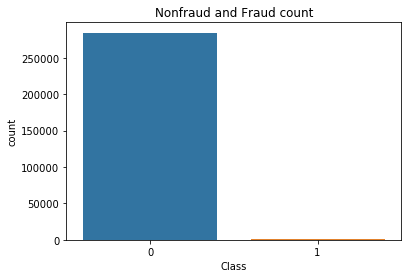

In [6]:
sns.countplot(df['Class'])
plt.title('Nonfraud and Fraud count')

### 3.0.1 Amount analysis

Text(0.5, 1.0, 'Median amount for Fraud and Nonfraud')

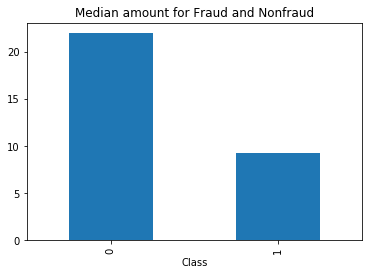

In [7]:
df.groupby('Class')['Amount'].median().plot.bar()
plt.title('Median amount for Fraud and Nonfraud')

Amount is highly concentrated

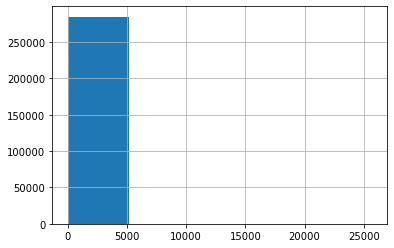

In [8]:
df['Amount'].hist(bins = 5)

In [9]:
print('Max of Amount: ', df['Amount'].max())
print('Min of Amount: ', df['Amount'].min())
print('Avg of Amount: ', df['Amount'].mean())

Max of Amount:  25691.16
Min of Amount:  0.0
Avg of Amount:  88.34961925093133


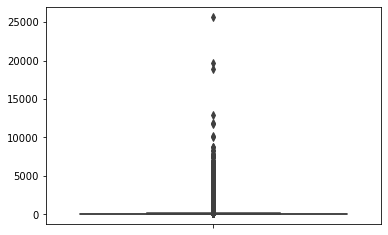

In [10]:
sns.boxplot(y = ['Amount'], data = df)

In [11]:
q1 = df['Amount'].quantile(0.25)
q3 = df['Amount'].quantile(0.75)
iqr = q3 + 1.5*q3

In [12]:
df_extreme = df[ df['Amount'] > iqr]

median value for fraud and nonfraud is evenly balanced

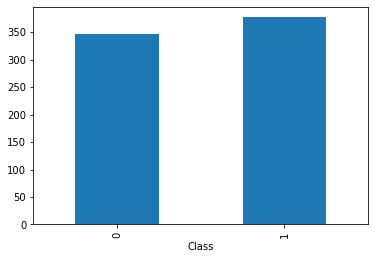

In [16]:
df_extreme.groupby('Class')['Amount'].median().plot.bar()

no evidence shows extreme values is related to amount of transaction

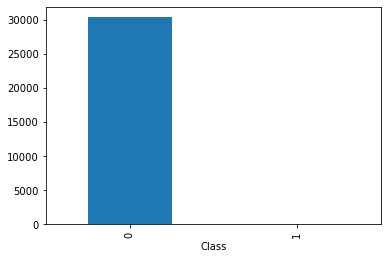

In [17]:
df_extreme.groupby('Class')['Amount'].count().plot.bar()

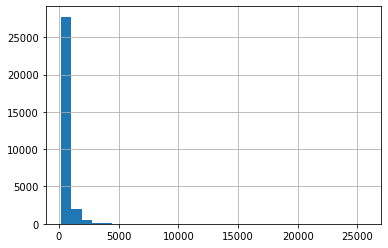

In [14]:
df_extreme['Amount'].hist(bins= 30)

### 3.0.2 Time analysis

Text(0.5, 1.0, 'Distribution of Time')

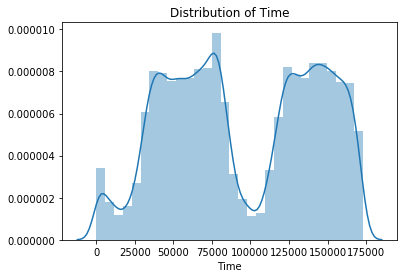

In [21]:
sns.distplot(df['Time'], bins = 30)
plt.title('Distribution of Time')

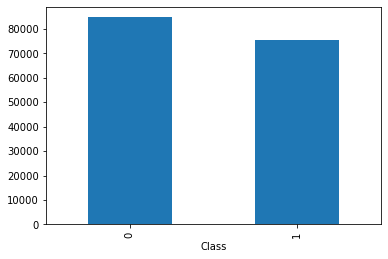

In [19]:
df.groupby('Class')['Time'].median().plot.bar()

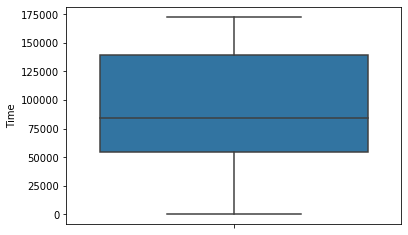

In [20]:
sns.boxplot(y = df['Time'])

#### 3.1 Scale data

given above boxplot: 
- use StandarScaler for Time
- use RobustScaler for Amount

In [25]:
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
df['Amount_scaled'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df.drop(['Amount'], inplace=True, axis = 1)

In [26]:
df['Time_scaled'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time'], inplace=True, axis = 1)

#### 3.2 Split data

In [27]:
y = df['Class']
X = df.drop(['Class'], axis = 1)

In [28]:
X.shape, y.shape

((284807, 30), (284807,))

In [29]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [30]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


In [ ]:
# X_train.shape, X_test.shape

### 4. Random Forest modelling

#### 4.1 Fit model

In [34]:
parameter_grid = {'n_estimators': [80, 100, 120],
                 'max_depth': [5, 10, None],
                 'max_features': [5, 6, 7]}

rf_model = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 101)
    
    
NUM_TRIALS = 5
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

for i in range(NUM_TRIALS):
    strat_cv = StratifiedKFold(n_splits = 5, random_state = 101)
    clf = GridSearchCV(estimator = rf_model, param_grid = parameter_grid, cv = strat_cv)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_
    
    
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')

KeyboardInterrupt: 

#### 4.2 Evaluate model

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
rf_model.score(X_test, y_test)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
cm = confusion_matrix( y_test, y_pred.round())
print(cm)

In [ ]:
plot_confusion_matrix(cm, classes = [0, 1], title = 'Confusion Matrix - Test dataset')

In [ ]:
print(accuracy_score(y_test, y_pred.round()))
print(precision_score(y_test, y_pred.round()))
print(recall_score(y_test, y_pred.round()))
print(f1_score(y_test, y_pred.round()))